# Data Pipelines in PyTorch 

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=brightgreen)
[![Source](https://img.shields.io/static/v1.svg?label=GitHub&message=Source&color=181717&logo=GitHub)](https://github.com/particle1331/fitter-happier-models/blob/master/docs/notebooks/pytorch/01-input-pipelines.ipynb)
[![Stars](https://img.shields.io/github/stars/particle1331/fitter-happier-models?style=social)](https://github.com/particle1331/fitter-happier-models)

---

## Introduction

To train neural networks, we typically need to stream large amounts of input data that is too large to fit in computer memory. Fortunately, training only requires a small sample of the data at each optimization step. But this requires loading and processing of data at train and inference time. Hence, we need to have efficient data loading and transformation pipelines. PyTorch provides the `Dataset` and `DataLoader` classes for efficient batch loading and shuffling, and preprocessing with transforms provided in libraries such as `torchvision.transforms` for images and `torchtext.transforms` for text. This notebook is based on section §12.3 of {cite}`raschka2022`.

In [131]:
import torch
import torch.nn.functional as F

import warnings
from pathlib import Path
from matplotlib_inline import backend_inline

DATASET_DIR = pathlib.Path("./data").absolute()
RANDOM_SEED = 42

warnings.simplefilter(action="ignore")
backend_inline.set_matplotlib_formats('svg')

print(torch.__version__)
print("mps:", torch.backends.mps.is_available())
g = torch.Generator().manual_seed(42)

1.12.1
mps: True


## Building data pipelines in PyTorch

### Dataset from tensors

Existing tensors can be loaded as data as follows:

In [132]:
from torch.utils.data import DataLoader, TensorDataset

t = torch.arange(6, dtype=torch.float32)
for item in DataLoader(t):
    print(item)

tensor([0.])
tensor([1.])
tensor([2.])
tensor([3.])
tensor([4.])
tensor([5.])


In [133]:
dataloader = DataLoader(t, batch_size=3, drop_last=True)
for batch in dataloader:
    print(batch)

tensor([0., 1., 2.])
tensor([3., 4., 5.])


To create a dataset from multiple tensors, we simply extend the `Dataset` class and implement `__len__` and `__getitem__`. This is pushed into a `DataLoader` which combines a dataset and a sampler to provide an iterable over the given dataset.

In [136]:
import pandas as pd
from torch.utils.data import Dataset

class JointDataset(Dataset):    # equiv. built-in: TensorDataset
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, i):
        return self.x[i], self.y[i]


x = torch.randn(size=(5, 2), generator=g, dtype=torch.float32)
y = torch.arange(10, dtype=torch.int32)

data = JointDataset(x, y) 
dataloader = DataLoader(data, batch_size=2, drop_last=False)
for batch in dataloader:
    x, y = batch
    print(pd.DataFrame({'x1': x[:, 0], 'x2': x[:, 1], 'y': y}))
    print()

         x1        x2  y
0  1.352548  0.686322  0
1 -0.327759  0.794969  1

         x1        x2  y
0  0.281520  0.056164  2
1  0.522716 -0.238357  3

         x1        x2  y
0 -0.049903  0.526337  4



This can be shuffled. And the data which cannot form a complete batch can be dropped. Observe that iterating over the same data loader multiple times result in different shuffles. This is desirable behavior that allows us to create **epochs** by simply looping over the data loader multiple times:

In [137]:
dataloader = DataLoader(data, batch_size=2, shuffle=True, drop_last=True, generator=g)

epochs = 2
for e in range(epochs):
    print(f"epoch: {e}")
    for batch in dataloader:
        x, y = batch
        print(pd.DataFrame({'x1': x[:, 0], 'x2': x[:, 1], 'y': y}))
        print()

epoch: 0
         x1        x2  y
0  1.352548  0.686322  0
1 -0.327759  0.794969  1

         x1        x2  y
0  0.281520  0.056164  2
1 -0.049903  0.526337  4

epoch: 1
         x1        x2  y
0 -0.049903  0.526337  4
1  0.281520  0.056164  2

         x1        x2  y
0  0.522716 -0.238357  3
1  1.352548  0.686322  0



### Dataset from local files

For large datasets, a good enough approach is to randomly shard the data into multiple files and have a dataset of filenames instead of actual data. The tradeoff is that data loading and processing occurs at train and inference time.

```{margin}
`kaggle/v1.5.12`
```

```bash
# https://www.kaggle.com/datasets/waifuai/cat2dog
kaggle datasets download -d waifuai/cat2dog -p ./data
unzip ./data/cat2dog.zip -d ./data/cat2dog > /dev/null
rm ./data/cat2dog.zip
```

```text
mkdir: ./data: File exists
Downloading cat2dog.zip to ./data
100%|██████████████████████████████████████| 27.4M/27.4M [00:09<00:00, 3.13MB/s]
```

Filenames can be collected using the `.glob` method of a `pathlib.Path` object:

In [63]:
import pathlib

DATASET_DIR = pathlib.Path("../data").absolute()
cat_imgdir_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainA"
dog_imgdir_path = DATASET_DIR / "cat2dog" / "cat2dog" / "trainB"

cat_file_list = sorted([str(path) for path in cat_imgdir_path.glob("*.jpg")])
dog_file_list = sorted([str(path) for path in dog_imgdir_path.glob("*.jpg")])

Visualizing image sets for cats and dogs:

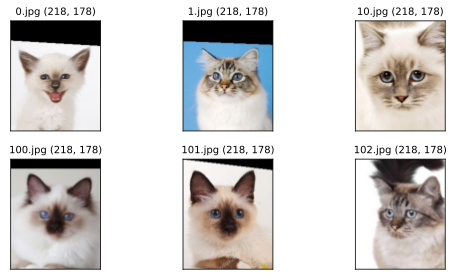

In [124]:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

fig = plt.figure(figsize=(8, 4))
for i, file in enumerate(cat_file_list[:6]):
    img = Image.open(file)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(f"{pathlib.Path(file).name} {np.array(img).shape[:2]}", size=10)
    
plt.tight_layout()
plt.show()

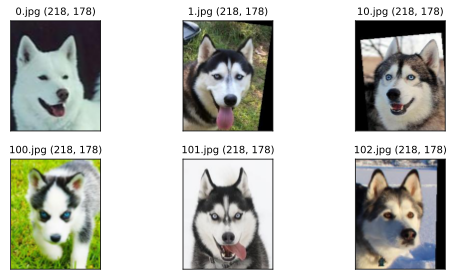

In [125]:
fig = plt.figure(figsize=(8, 4))
for i, file in enumerate(dog_file_list[:6]):
    img = Image.open(file)
    ax = fig.add_subplot(2, 3, i+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(f"{pathlib.Path(file).name} {np.array(img).shape[:2]}", size=10)
    
plt.tight_layout()
plt.show()

Creating a combined dataset with labels `0` to cats and `1` to dogs. Loading the data from disk occurs inside the `__getitem__` method followed by applying the transformation for preprocessing:

In [126]:
class ImageDataset(Dataset):
    def __init__(self, file_list, labels, transform=None):
        self.file_list = file_list
        self.labels = labels
        self.transform = transform

    def __getitem__(self, i):
        file = self.file_list[i]
        label = self.labels[i]
        img = Image.open(file)
        img = self.transform(img) if self.transform is not None else img
        return img, label

    def __len__(self):
        return len(self.file_list)

### Transforms

Trying out a simple resize followed by a random vertical flip:

In [127]:
import torchvision.transforms as transforms

img_height, img_width = 218, 218
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((img_height, img_width)),
    transforms.RandomCrop((int(img_height*0.75), int(img_width*0.75)))
])

Plotting one batch:

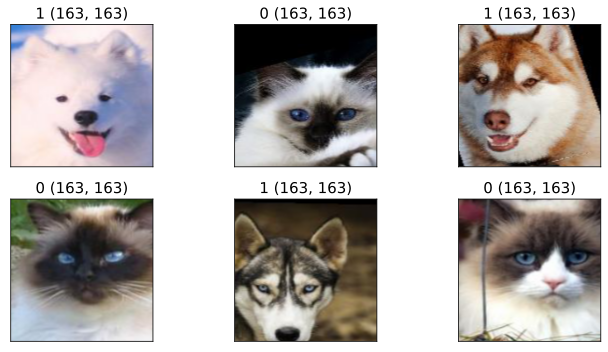

In [129]:
file_list = cat_file_list + dog_file_list
labels = [0]*len(cat_file_list) + [1]*len(dog_file_list)
dataset = ImageDataset(file_list=file_list, labels=labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=6, shuffle=True, generator=g)

# Plotting
img, label = next(iter(dataloader))

fig, ax = plt.subplots(2, 3, figsize=(10, 5))
for i in range(6):
    ax[divmod(i, 3)].imshow(img[i].numpy().transpose((1, 2, 0)))
    ax[divmod(i, 3)].set_xticks([])
    ax[divmod(i, 3)].set_yticks([])
    ax[divmod(i, 3)].set_title(f"{label[i]} {img[i].numpy().transpose((1, 2, 0)).shape[:2]}", size=15)
    
plt.tight_layout();

## Datasets from `torchvision.datasets`

The [`torchvision.datasets`](https://pytorch.org/vision/stable/datasets.html) library provides a collection of freely available 
datasets for training or evaluating deep learning models which allows for quick experimentation. Similarly, we have [`torchtext.datasets`](https://pytorch.org/text/stable/datasets.html) for NLP tasks. These datasets are all subclasses of `Dataset` so all the functions we covered above can be used directly.

In [99]:
import torchvision

class_dict = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

cifar10_dataset = torchvision.datasets.CIFAR10(
    DATASET_DIR, train=True, download=True,
    transform=transforms.ToTensor(),
    target_transform=lambda t: class_dict[t]
)

Files already downloaded and verified


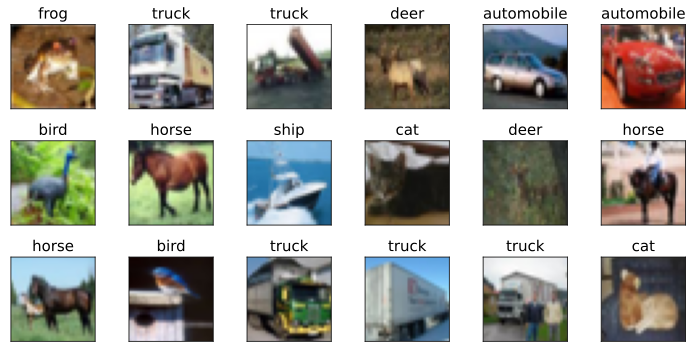

In [100]:
img, label = next(iter(DataLoader(cifar10_dataset, batch_size=32)))

fig, ax = plt.subplots(3, 6, figsize=(10, 5))
for i in range(18):
    ax[divmod(i, 6)].imshow(img[i].numpy().transpose((1, 2, 0)))
    ax[divmod(i, 6)].set_xticks([])
    ax[divmod(i, 6)].set_yticks([])
    ax[divmod(i, 6)].set_title(f"{label[i]}", size=15)

fig.tight_layout()

## Building a neural net in PyTorch

```{margin}
⚠️ This section requires knowledge of the **Keras API** discussed [here](https://particle1331.github.io/inefficient-networks/notebooks/tensorflow/02-tensorflow-mechanics.html#keras-api).
```

So far we have learned about the basic utility components of 
TensorFlow for manipulating tensors and organizing data into formats that we 
can iterate over during training. In this section, we look at how to feed data into TensorFlow models.

### Custom training loop

**Dataset.** In this section, we train a simple linear regression model derived from `tf.keras.Model` by implementing SGD from scratch. The loop iterates over a `tf.data.Dataset` object which acts as a data loader. We use a 2-layer MLP to learn the artificial dataset composed of 10 points below.

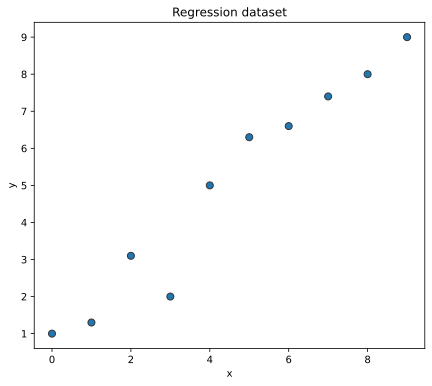

In [ ]:
import numpy as np

X_train = np.arange(10).reshape((10, 1))
y_train = np.array([1.0, 1.3, 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

plt.figure(figsize=(7, 6), dpi=80)
plt.scatter(X_train, y_train, edgecolor="#333", s=50)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Regression dataset')
plt.show()

In [ ]:
X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
ds_train_orig = tf.data.Dataset.from_tensor_slices((
    tf.cast(X_train_norm, tf.float32), 
    tf.cast(y_train, tf.float32)
))

<br>

**Model.** We implement a univariate linear regression model by subclassing the Keras `Model` class.

In [ ]:
class RegressionModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.w = tf.Variable(0.0, name='weight')
        self.b = tf.Variable(0.0, name='bias')
    
    def call(self, x):
        return self.w * x + self.b

<br>

**Training loop.** The `train` function implements a single step of SGD optimization where gradients of the MSE loss function obtained automatically are used to update the weight `w` and bias `b`. Note that using `count=None` on `repeat` will create a batched version of the dataset that repeats infinitely many times. But since we implement no early stopping mechanism, we set `count=200` to train the model for 200 epochs. 

In [ ]:
def loss_fn(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def train(model, inputs, outputs, learning_rate):
    with tf.GradientTape() as tape:
        loss = loss_fn(model(inputs), outputs)
    
    dw, db = tape.gradient(loss, [model.w, model.b])
    model.w.assign_sub(learning_rate * dw)
    model.b.assign_sub(learning_rate * db)

Alternatively, we can exploit the `apply_gradients` method of built-in Keras optimizers:

```python
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
optimizer.apply_gradients(zip([dw, db], [model.w, model.b]))
```

Finally, we can implement the train loop by iterating over the batch loader and applying the train step at each iteration:

In [ ]:
# Hyperparameters
NUM_EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 1

# Instantiate model
model = RegressionModel()

# Create batch loader
ds_train = ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train = ds_train.batch(1)
ds_train = ds_train.repeat(count=NUM_EPOCHS)

ws, bs = [], []
steps_per_epoch = np.floor(len(y_train) / BATCH_SIZE)
for i, batch in enumerate(ds_train):
    ws.append(model.w.numpy())
    bs.append(model.b.numpy())

    bx, by = batch
    loss_value = loss_fn(model(bx), by)
    train(model, bx, by, learning_rate=LEARNING_RATE)
    
    if i%100==0:
        print(f'Epoch {i // int(steps_per_epoch):4d} Loss {loss_value:>8.4f}')


2022-04-28 22:59:46.027782: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Epoch    0 Loss   1.0000
Epoch   10 Loss   0.7545
Epoch   20 Loss  12.3543
Epoch   30 Loss  16.7208
Epoch   40 Loss   0.1441
Epoch   50 Loss   0.0592
Epoch   60 Loss   0.2374
Epoch   70 Loss   4.8255
Epoch   80 Loss   2.3959
Epoch   90 Loss   1.5433
Epoch  100 Loss   0.7149
Epoch  110 Loss   0.1239
Epoch  120 Loss   0.6282
Epoch  130 Loss   0.1058
Epoch  140 Loss   1.7988
Epoch  150 Loss   0.3787
Epoch  160 Loss   0.0044
Epoch  170 Loss   0.1000
Epoch  180 Loss   0.0015
Epoch  190 Loss   0.0559


<br>

**History.** Here we plot the learned model and the history of its parameters. As training progresses, the weight and bias converge to an optimal value.

Final Parameters: w=2.6577, b=4.8799


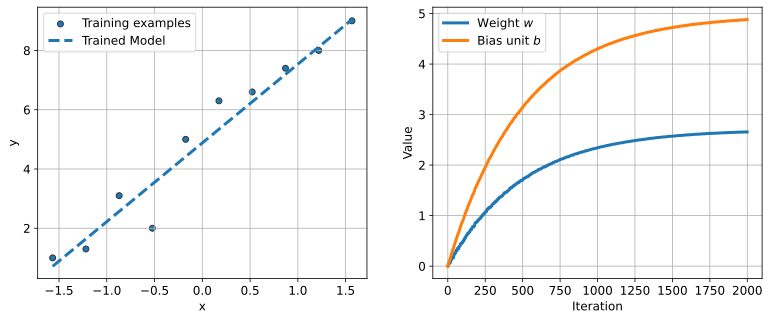

In [ ]:
print(f'Final Parameters: w={model.w.numpy():.4f}, b={model.b.numpy():.4f}')

# Generate test set; here test = inference
X_test = np.linspace(0, 9, num=100).reshape(-1, 1)
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)

# Get predictions on test set
y_pred = model(tf.cast(X_test_norm, dtype=tf.float32))

# Plot learned model
fig = plt.figure(figsize=(13, 5), dpi=600)
ax = fig.add_subplot(1, 2, 1)
plt.scatter(X_train_norm, y_train, c="#1F77B4", edgecolor="#333")
plt.plot(X_test_norm, y_pred, linestyle="--", color='#1F77B4', lw=3)
plt.legend(['Training examples', 'Trained Model'], fontsize=12)
ax.set_xlabel('x', size=12)
ax.set_ylabel('y', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

# Plot parameter history
ax = fig.add_subplot(1, 2, 2)
plt.plot(ws, lw=3)
plt.plot(bs, lw=3)
plt.legend([r'Weight $w$', r'Bias unit $b$'], fontsize=12)
ax.set_xlabel('Iteration', size=12)
ax.set_ylabel('Value', size=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid()

plt.show()

### Keras `fit` function

In this section, we look at how to obtain a dataset from `tensorflow_datasets` and use it to train a Keras model. In particular we will use the Iris Dataset which consists of 150 observations of the petal and sepal lengths, and petal and sepal widths of 3 different types of irises.


<!-- ```{figure} ../../img/iris.jpeg
---
name: iris
---
From left to right: [Iris setosa](https://commons.wikimedia.org/w/index.php?curid=170298), [Iris versicolor](https://commons.wikimedia.org/w/index.php?curid=248095), and [Iris virginica](https://www.flickr.com/photos/33397993@N05/3352169862).
``` -->

In [ ]:
iris, iris_info = tfds.load('iris', with_info=True)
print(iris_info.splits) 

{'train': <SplitInfo num_examples=150, num_shards=1>}


In [ ]:
type(iris['train'])

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

<br>

**Dataset split.** This only has a train set, so we have to manually split for validation. We can do this with the `.take()` and `.skip()` methods. But this can lead to some unexpected behavior after calling `.shuffle` which converts the dataset to a `ShuffleDataset` which would shuffle the after the initial application of take when creating the train dataset. A workaround is to set `reshuffle_each_iteration` to `False`. 

In [ ]:
tf.random.set_seed(1)

# Shuffle data
dataset_orig = iris['train']
N = len(dataset_orig)
dataset_shuffled = dataset_orig.shuffle(N, reshuffle_each_iteration=False)

# Split into train and test sets; transform
train_dataset = dataset_shuffled.take(100)
test_dataset = dataset_shuffled.skip(100)
print("Train size:", len(train_dataset))
print("Test size: ", len(test_dataset))

train_dataset = train_dataset.map(lambda d: (d['features'], d['label']))
test_dataset = test_dataset.map(lambda d: (d['features'], d['label']))

Train size: 100
Test size:  50


<br>

**Model.** A two-layer MLP with sigmoid activations should suffice to learn 100 data points:

In [ ]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')
])

iris_model.summary() # No need to call .build(), input_shape passed in first dense layer.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


<br>

**Training.** Observe that the Keras `fit` method works with `tf.data` batch loaders:

In [ ]:
# Use sparse since targets are 0, 1, 2
iris_model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.1), 
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Hyperparameters
NUM_EPOCHS = 50
BATCH_SIZE = 8

# This will be iterated over in the fit method.
train_loader = train_dataset.shuffle(buffer_size=100)
train_loader = train_loader.batch(batch_size=BATCH_SIZE, drop_remainder=True)
train_loader = train_loader.prefetch(buffer_size=10) # Prepare next elements 

# Train model
history = iris_model.fit(
    train_loader, 
    epochs=NUM_EPOCHS,
    verbose=1,
)

Epoch 1/50
12/12 [==============================] - 0s 4ms/step - loss: 1.0202 - accuracy: 0.5000
Epoch 2/50
 1/12 [=>............................] - ETA: 0s - loss: 0.9636 - accuracy: 0.6250

2022-04-28 22:59:51.692325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


12/12 [==============================] - 0s 4ms/step - loss: 0.8680 - accuracy: 0.7083
Epoch 3/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7913 - accuracy: 0.6979
Epoch 4/50
12/12 [==============================] - 0s 3ms/step - loss: 0.7268 - accuracy: 0.7708
Epoch 5/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6433 - accuracy: 0.8021
Epoch 6/50
12/12 [==============================] - 0s 3ms/step - loss: 0.6009 - accuracy: 0.7396
Epoch 7/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5622 - accuracy: 0.7812
Epoch 8/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.7708
Epoch 9/50
12/12 [==============================] - 0s 3ms/step - loss: 0.5010 - accuracy: 0.8229
Epoch 10/50
12/12 [==============================] - 0s 4ms/step - loss: 0.5125 - accuracy: 0.7292
Epoch 11/50
12/12 [==============================] - 0s 3ms/step - loss: 0.4868 - accuracy: 0.7812
Epoch 12/50
12/12 [==========

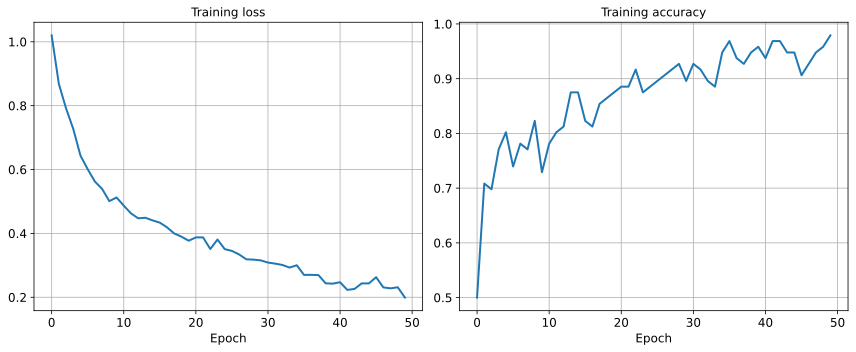

In [ ]:
hist = history.history

# Train loss plot
fig, ax = plt.subplots(1, 2, figsize=(12, 5), dpi=300)
ax[0].plot(hist['loss'], lw=2)
ax[0].set_title('Training loss', size=12)
ax[0].set_xlabel('Epoch', size=12)
ax[0].tick_params(axis='both', which='major', labelsize=12)
ax[0].grid()

# Accuracy plot
ax[1].plot(hist['accuracy'], lw=2)
ax[1].set_title('Training accuracy', size=12)
ax[1].set_xlabel('Epoch', size=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].grid()

plt.tight_layout()

<br>

**Evaluation.** Keras methods `evaluate` (and also `predict`) work nicely with TF dataset objects. We can load the test data into the evaluator as follows:

In [ ]:
results = iris_model.evaluate(test_dataset.batch(1), verbose=0) # 50 batches of size 1
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.2446   Test Acc.: 0.9200


2022-04-28 22:59:54.910905: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
